In [2]:
!pip install kagglehub

  Using cached kagglehub-0.3.12-py3-none-any.whl.metadata (38 kB)
Using cached kagglehub-0.3.12-py3-none-any.whl (67 kB)


In [4]:
import kagglehub
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.utils import resample
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
from pycaret.classification import *

In [ ]:
# import bộ dữ liệu CICIDS từ kaggle về
# tôi sử dụng bộ dữ liệu IDS 2018 Intrusion CSVs (CSE-CIC-IDS2018)

import kagglehub

# Download latest version to the current directory
path = kagglehub.dataset_download("solarmainframe/ids-intrusion-csv")
print("Path to dataset files:", path)


Path to dataset files: C:\Users\DELL\.cache\kagglehub\datasets\solarmainframe\ids-intrusion-csv\versions\1


In [8]:
#display the files in path
import os
for file in os.listdir(path):
    print(file)


02-14-2018.csv
02-15-2018.csv
02-16-2018.csv
02-20-2018.csv
02-21-2018.csv
02-22-2018.csv
02-23-2018.csv
02-28-2018.csv
03-01-2018.csv
03-02-2018.csv


In [ ]:
import pandas as pd
# Load the dataset into a pandas DataFrame
df = pd.read_csv(os.path.join(path, "03-02-2018.csv"))
df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,443,6,02/03/2018 08:47:38,141385,9,7,553,3773.0,202,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,49684,6,02/03/2018 08:47:38,281,2,1,38,0.0,38,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,443,6,02/03/2018 08:47:40,279824,11,15,1086,10527.0,385,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,443,6,02/03/2018 08:47:40,132,2,0,0,0.0,0,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,443,6,02/03/2018 08:47:41,274016,9,13,1285,6141.0,517,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [11]:
#display data colume Label
df['Label'].value_counts()

Label
Benign    762384
Bot       286191
Name: count, dtype: int64

In [6]:
# tải bộ dữ liệu CIC-IDS- 2017
import kagglehub

# Download latest version
path_2017 = kagglehub.dataset_download("chethuhn/network-intrusion-dataset")

print("Path to dataset files:", path_2017)

Path to dataset files: C:\Users\DELL\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1


In [20]:
#display the files in path
import os
for file in os.listdir(path_2017):
    print(file)

Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Friday-WorkingHours-Morning.pcap_ISCX.csv
Monday-WorkingHours.pcap_ISCX.csv
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Tuesday-WorkingHours.pcap_ISCX.csv
Wednesday-workingHours.pcap_ISCX.csv


In [21]:
#merge tất các file csv trong thư mục path_2017
import glob
import pandas as pd
# Get all CSV files in the directory
csv_files = glob.glob(os.path.join(path_2017, "*.csv"))
# Read and concatenate all CSV files into a single DataFrame
df_2017 = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)
# Display the first few rows of the DataFrame
df_2017

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,53,32215,4,2,112,152,28,28,28.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,53,324,2,2,84,362,42,42,42.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,58030,82,2,1,31,6,31,0,15.5,21.92031,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,53,1048635,6,2,192,256,32,32,32.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [6]:
df_2017.shape

(2830743, 79)

In [22]:
# get all name of columns
columns_2017 = df_2017.columns.tolist()
# Display the columns
print("Columns in the dataset:", columns_2017)

Columns in the dataset: [' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK 

In [23]:
df_2017.columns = df_2017.columns.str.strip()
print(df_2017['Label'].value_counts())
df_2017['Label'] = df_2017['Label'].str.strip()

mapping = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'PortScan': 'PortScan',
    'DoS GoldenEye': 'DoS',
    'DoS Hulk': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'DoS slowloris': 'DoS'
}
df_2017['Label_grp'] = df_2017['Label'].map(mapping).fillna('Other')
print("New class counts:")
print(df_2017['Label_grp'].value_counts())

Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64
New class counts:
Label_grp
BENIGN      2273097
DoS          252661
PortScan     158930
DDoS         128027
Other         18028
Name: count, dtype: int64


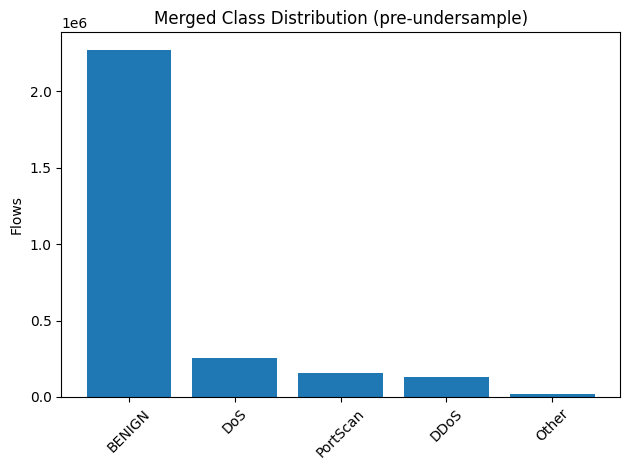

In [24]:
import matplotlib.pyplot as plt
counts = df_2017['Label_grp'].value_counts()
plt.figure()
plt.bar(counts.index, counts.values)
plt.xticks(rotation=45)
plt.title("Merged Class Distribution (pre‐undersample)")
plt.ylabel("Flows")
plt.tight_layout()
plt.show()

In [25]:
# vì số lượng mẫu benign và mẫu bất thường chênh lêch quá lớn nên tôi sẽ tiến hành undersample với số lượng mẫu benign, DoS, DDoS, PortScan là 100.000 mẫu
from sklearn.utils import resample

max_samples = 100000
df_label_downsampled = []
for label in df_2017['Label_grp'].unique():
    df_label = df_2017[df_2017['Label_grp'] == label]
    if len(df_label) > max_samples:
        df_label = resample(df_label, n_samples=max_samples, random_state=42)
    df_label_downsampled.append(df_label)
# Concatenate all downsampled DataFrames
df_downsampled = pd.concat(df_label_downsampled, ignore_index=True)
# Display the shape of the downsampled DataFrame
print("Shape of downsampled DataFrame:", df_downsampled.shape)
# New class counts after undersampling:
print("New class counts after undersampling:")
print(df_downsampled['Label_grp'].value_counts())

Shape of downsampled DataFrame: (418028, 80)
New class counts after undersampling:
Label_grp
BENIGN      100000
DDoS        100000
PortScan    100000
DoS         100000
Other        18028
Name: count, dtype: int64


In [28]:
df_downsampled

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label_grp
0,443,3,2,0,12,0,6,6,6.000000,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,BENIGN,BENIGN
1,53,193,2,2,60,188,30,30,30.000000,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,BENIGN,BENIGN
2,60145,31,1,1,0,0,0,0,0.000000,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,BENIGN,BENIGN
3,53,140894,1,1,64,157,64,64,64.000000,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,BENIGN,BENIGN
4,443,21072988,15,12,1919,5389,777,0,127.933333,271.190620,...,182895.0,124331.99955,270811,94979,10018510.0,71436.169676,10069023,9967997,BENIGN,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418023,80,3,2,0,0,0,0,0,0.000000,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,DoS Hulk,DoS
418024,80,4,2,0,0,0,0,0,0.000000,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,DoS Hulk,DoS
418025,80,99307967,8,6,361,11595,361,0,45.125000,127.632774,...,995.0,0.00000,995,995,99300000.0,0.000000,99300000,99300000,DoS Hulk,DoS
418026,80,990,2,0,0,0,0,0,0.000000,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,DoS Hulk,DoS


In [29]:
# save the undersampled DataFrame to a new CSV file
output_file = os.path.join(path_2017, "undersampled_dataset.csv")
df_downsampled.to_csv(output_file, index=False)
print(f"Undersampled dataset saved to {output_file}")

Undersampled dataset saved to C:\Users\DELL\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\undersampled_dataset.csv


In [7]:
# đọc file downsampled_dataset.csv
df_downsampled = pd.read_csv(os.path.join(path_2017, "undersampled_dataset.csv"))

In [32]:
df_downsampled

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label_grp
0,443,3,2,0,12,0,6,6,6.000000,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,BENIGN,BENIGN
1,53,193,2,2,60,188,30,30,30.000000,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,BENIGN,BENIGN
2,60145,31,1,1,0,0,0,0,0.000000,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,BENIGN,BENIGN
3,53,140894,1,1,64,157,64,64,64.000000,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,BENIGN,BENIGN
4,443,21072988,15,12,1919,5389,777,0,127.933333,271.190620,...,182895.0,124331.99955,270811,94979,10018510.0,71436.169676,10069023,9967997,BENIGN,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418023,80,3,2,0,0,0,0,0,0.000000,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,DoS Hulk,DoS
418024,80,4,2,0,0,0,0,0,0.000000,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,DoS Hulk,DoS
418025,80,99307967,8,6,361,11595,361,0,45.125000,127.632774,...,995.0,0.00000,995,995,99300000.0,0.000000,99300000,99300000,DoS Hulk,DoS
418026,80,990,2,0,0,0,0,0,0.000000,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,DoS Hulk,DoS


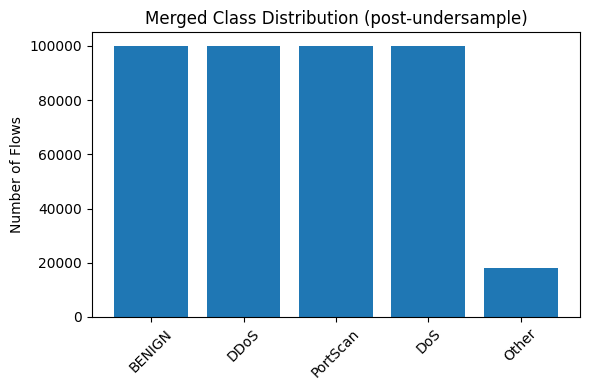

In [33]:
import numpy as np
dist_after = df_downsampled['Label_grp'].value_counts()
plt.figure(figsize=(6,4))
plt.bar(dist_after.index, dist_after.values)
plt.xticks(rotation=45)
plt.title('Merged Class Distribution (post-undersample)')
plt.ylabel('Number of Flows')
plt.tight_layout()
plt.show()


In [34]:
#Preprocess features & labels
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1) fill / replace
df_downsampled.fillna(0, inplace=True)
df_downsampled.replace([np.inf, -np.inf], 0, inplace=True)

# 2) feature / label split
#feature_cols = df_downsampled.select_dtypes(include=[np.number]).columns.tolist()
# drop any numeric-derived Label columns
#feature_cols = [c for c in feature_cols if 'label' not in c.lower()]
#X = df_downsampled[feature_cols].values

#le = LabelEncoder()
#y = le.fit_transform(df_downsampled['Label_grp'].values)

# 3) scale
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

In [35]:
df_downsampled

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label_grp
0,443,3,2,0,12,0,6,6,6.000000,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,BENIGN,BENIGN
1,53,193,2,2,60,188,30,30,30.000000,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,BENIGN,BENIGN
2,60145,31,1,1,0,0,0,0,0.000000,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,BENIGN,BENIGN
3,53,140894,1,1,64,157,64,64,64.000000,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,BENIGN,BENIGN
4,443,21072988,15,12,1919,5389,777,0,127.933333,271.190620,...,182895.0,124331.99955,270811,94979,10018510.0,71436.169676,10069023,9967997,BENIGN,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418023,80,3,2,0,0,0,0,0,0.000000,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,DoS Hulk,DoS
418024,80,4,2,0,0,0,0,0,0.000000,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,DoS Hulk,DoS
418025,80,99307967,8,6,361,11595,361,0,45.125000,127.632774,...,995.0,0.00000,995,995,99300000.0,0.000000,99300000,99300000,DoS Hulk,DoS
418026,80,990,2,0,0,0,0,0,0.000000,0.000000,...,0.0,0.00000,0,0,0.0,0.000000,0,0,DoS Hulk,DoS


In [36]:
# chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_downsampled, test_size=0.2, random_state=42, stratify= df_downsampled['Label_grp'])

In [37]:
from pycaret.classification import *
# Initialize the setup

clf = setup(data=pd.DataFrame(df_train), 
            target='Label_grp', 
            session_id=42, 
            normalize=True, 
            normalize_method='zscore',  
            html=False)
models()

                    Description  \
0                    Session id   
1                        Target   
2                   Target type   
3                Target mapping   
4           Original data shape   
5        Transformed data shape   
6   Transformed train set shape   
7    Transformed test set shape   
8              Numeric features   
9          Categorical features   
10                   Preprocess   
11              Imputation type   
12           Numeric imputation   
13       Categorical imputation   
14     Maximum one-hot encoding   
15              Encoding method   
16                    Normalize   
17             Normalize method   
18               Fold Generator   
19                  Fold Number   
20                     CPU Jobs   
21                      Use GPU   
22               Log Experiment   
23              Experiment Name   
24                          USI   

                                                Value  
0                                

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [41]:
# Compare models
best_model = compare_models()


                                    Model  Accuracy  AUC  Recall   Prec.  \
gbc          Gradient Boosting Classifier    0.8000  0.0  0.8000  0.8000   
nb                            Naive Bayes    0.7000  0.7  0.7000  0.7000   
dt               Decision Tree Classifier    0.7000  0.7  0.7000  0.7000   
ridge                    Ridge Classifier    0.7000  0.0  0.7000  0.7000   
knn                K Neighbors Classifier    0.6999  0.7  0.6999  0.6999   
svm                   SVM - Linear Kernel    0.6999  0.0  0.6999  0.6999   
ada                  Ada Boost Classifier    0.6698  0.0  0.6698  0.6442   
rf               Random Forest Classifier    0.6000  0.6  0.6000  0.6000   
et                 Extra Trees Classifier    0.6000  0.6  0.6000  0.6000   
xgboost         Extreme Gradient Boosting    0.6000  0.6  0.6000  0.6000   
lightgbm  Light Gradient Boosting Machine    0.6000  0.6  0.6000  0.6000   
lda          Linear Discriminant Analysis    0.5349  0.0  0.5349  0.5130   
qda       Qu

In [8]:
#Preprocess features & labels
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1) fill / replace
df_downsampled.fillna(0, inplace=True)
df_downsampled.replace([np.inf, -np.inf], 0, inplace=True)

# 2) feature / label split
feature_cols = df_downsampled.select_dtypes(include=[np.number]).columns.tolist()
# drop any numeric-derived Label columns
feature_cols = [c for c in feature_cols if 'label' not in c.lower()]
X = df_downsampled[feature_cols].values

le = LabelEncoder()
y = le.fit_transform(df_downsampled['Label_grp'].values)

# 3) scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [51]:
!pip install torch-geometric

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   ------------------------------------ --- 1.0/1.1 MB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 1.9 MB/s eta 0:00:00


In [9]:
import torch
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import coo_matrix
k = 10
A = kneighbors_graph(X_scaled, n_neighbors=k,
                    mode='connectivity', include_self=False).tocoo()
edge_index = torch.tensor([A.row, A.col], dtype=torch.long)

data = Data(
    x=torch.tensor(X_scaled, dtype=torch.float),
    edge_index=edge_index,
    y=torch.tensor(y, dtype=torch.long)
)
print(f"Graph: {data.num_nodes} nodes, {data.num_edges//2} undirected edges")

Graph: 418028 nodes, 2090140 undirected edges


In [10]:
num_nodes = data.num_nodes
idx = np.arange(num_nodes)
train_idx, test_idx = train_test_split(
    idx, test_size=0.2, random_state=42, stratify=y
)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask  = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
test_mask [test_idx] = True

data.train_mask = train_mask
data.test_mask  = test_mask

In [15]:
from torch_geometric.nn import GCNConv
from collections import Counter
import torch.nn.functional as F
class GCN(torch.nn.Module):
    def __init__(self, in_feats, hid_feats, num_classes):
        super().__init__()
        self.conv1 = GCNConv(in_feats, hid_feats)
        self.conv2 = GCNConv(hid_feats, hid_feats)
        self.lin   = torch.nn.Linear(hid_feats, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return F.log_softmax(self.lin(x), dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(data.num_node_features, 64, len(le.classes_)).to(device)
data = data.to(device)

# compute class weights
counts = Counter(y)
total = sum(counts.values())
weights = torch.tensor([total/counts[i] for i in range(len(le.classes_))],
                       dtype=torch.float, device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss(weight=weights)

In [16]:
history = {'loss': [], 'train_acc': [], 'test_acc': []}
best_test, patience, stall = 0.0, 10, 0

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    pred = out.argmax(dim=1)
    train_acc = pred[data.train_mask].eq(data.y[data.train_mask]).float().mean().item()
    test_acc  = pred[data.test_mask].eq(data.y[data.test_mask]).float().mean().item()

    history['loss'].append(loss.item())
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)

    print(f"Epoch {epoch:03d} | Loss {loss:.4f} | "
          f"TrainAcc {train_acc:.4f} | TestAcc {test_acc:.4f}")

    if test_acc > best_test:
        best_test, stall = test_acc, 0
    else:
        stall += 1
        if stall >= patience:
            print("Early stopping.")
            break

Epoch 001 | Loss 1.5967 | TrainAcc 0.2278 | TestAcc 0.2297
Epoch 002 | Loss 1.2958 | TrainAcc 0.6397 | TestAcc 0.6405
Epoch 003 | Loss 1.0877 | TrainAcc 0.6770 | TestAcc 0.6777
Epoch 004 | Loss 0.9087 | TrainAcc 0.7208 | TestAcc 0.7214
Epoch 005 | Loss 0.7643 | TrainAcc 0.8119 | TestAcc 0.8112
Epoch 006 | Loss 0.6516 | TrainAcc 0.8461 | TestAcc 0.8464
Epoch 007 | Loss 0.5582 | TrainAcc 0.8460 | TestAcc 0.8462
Epoch 008 | Loss 0.4831 | TrainAcc 0.8399 | TestAcc 0.8397
Epoch 009 | Loss 0.4252 | TrainAcc 0.8842 | TestAcc 0.8843
Epoch 010 | Loss 0.3863 | TrainAcc 0.9047 | TestAcc 0.9043
Epoch 011 | Loss 0.3491 | TrainAcc 0.9069 | TestAcc 0.9067
Epoch 012 | Loss 0.3196 | TrainAcc 0.9096 | TestAcc 0.9096
Epoch 013 | Loss 0.2909 | TrainAcc 0.9228 | TestAcc 0.9234
Epoch 014 | Loss 0.2767 | TrainAcc 0.9358 | TestAcc 0.9363
Epoch 015 | Loss 0.2525 | TrainAcc 0.9347 | TestAcc 0.9348
Epoch 016 | Loss 0.2410 | TrainAcc 0.9301 | TestAcc 0.9299
Epoch 017 | Loss 0.2297 | TrainAcc 0.9381 | TestAcc 0.93

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Chuyển sang tensor
X_train = torch.tensor(X_train, dtype=torch.float)
X_test  = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test  = torch.tensor(y_test, dtype=torch.long)



In [18]:
# Định nghĩa ANN
class ANN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hid_dim)
        self.fc2 = nn.Linear(hid_dim, hid_dim)
        self.fc3 = nn.Linear(hid_dim, out_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.fc3(x), dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ANN(X_train.shape[1], 64, len(np.unique(y))).to(device)
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Loss và optimizer
class_counts = torch.bincount(y_train)
weights = (1.0 / class_counts.float()).to(device)
criterion = nn.NLLLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [26]:
# Huấn luyện
for epoch in range(1, 301):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    pred = out.argmax(dim=1)
    train_acc = (pred == y_train).float().mean().item()
    with torch.no_grad():
        test_pred = model(X_test).argmax(dim=1)
        test_acc = (test_pred == y_test).float().mean().item()
    print(f"Epoch {epoch:03d} | Loss {loss:.4f} | TrainAcc {train_acc:.4f} | TestAcc {test_acc:.4f}")



Epoch 001 | Loss 0.0405 | TrainAcc 0.9874 | TestAcc 0.9870
Epoch 002 | Loss 0.0404 | TrainAcc 0.9874 | TestAcc 0.9870
Epoch 003 | Loss 0.0404 | TrainAcc 0.9874 | TestAcc 0.9870
Epoch 004 | Loss 0.0403 | TrainAcc 0.9874 | TestAcc 0.9870
Epoch 005 | Loss 0.0402 | TrainAcc 0.9874 | TestAcc 0.9870
Epoch 006 | Loss 0.0401 | TrainAcc 0.9874 | TestAcc 0.9871
Epoch 007 | Loss 0.0400 | TrainAcc 0.9875 | TestAcc 0.9871
Epoch 008 | Loss 0.0399 | TrainAcc 0.9875 | TestAcc 0.9872
Epoch 009 | Loss 0.0398 | TrainAcc 0.9875 | TestAcc 0.9872
Epoch 010 | Loss 0.0397 | TrainAcc 0.9875 | TestAcc 0.9873
Epoch 011 | Loss 0.0396 | TrainAcc 0.9876 | TestAcc 0.9874
Epoch 012 | Loss 0.0395 | TrainAcc 0.9876 | TestAcc 0.9874
Epoch 013 | Loss 0.0394 | TrainAcc 0.9876 | TestAcc 0.9873
Epoch 014 | Loss 0.0394 | TrainAcc 0.9876 | TestAcc 0.9873
Epoch 015 | Loss 0.0393 | TrainAcc 0.9876 | TestAcc 0.9874
Epoch 016 | Loss 0.0393 | TrainAcc 0.9876 | TestAcc 0.9874
Epoch 017 | Loss 0.0392 | TrainAcc 0.9876 | TestAcc 0.98

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
with torch.no_grad():
    y_pred = model(X_test).argmax(dim=1).cpu().numpy()
    y_true = y_test.cpu().numpy()
print("Classification Report:\n", classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     20000
           1       1.00      1.00      1.00     20000
           2       0.99      1.00      0.99     20000
           3       0.91      0.99      0.95      3606
           4       0.99      1.00      0.99     20000

    accuracy                           0.99     83606
   macro avg       0.98      0.99      0.98     83606
weighted avg       0.99      0.99      0.99     83606

Confusion Matrix:
 [[19173    11   234   323   259]
 [   10 19990     0     0     0]
 [   12     0 19974    13     1]
 [   14     0    10  3582     0]
 [    1     0    10     1 19988]]


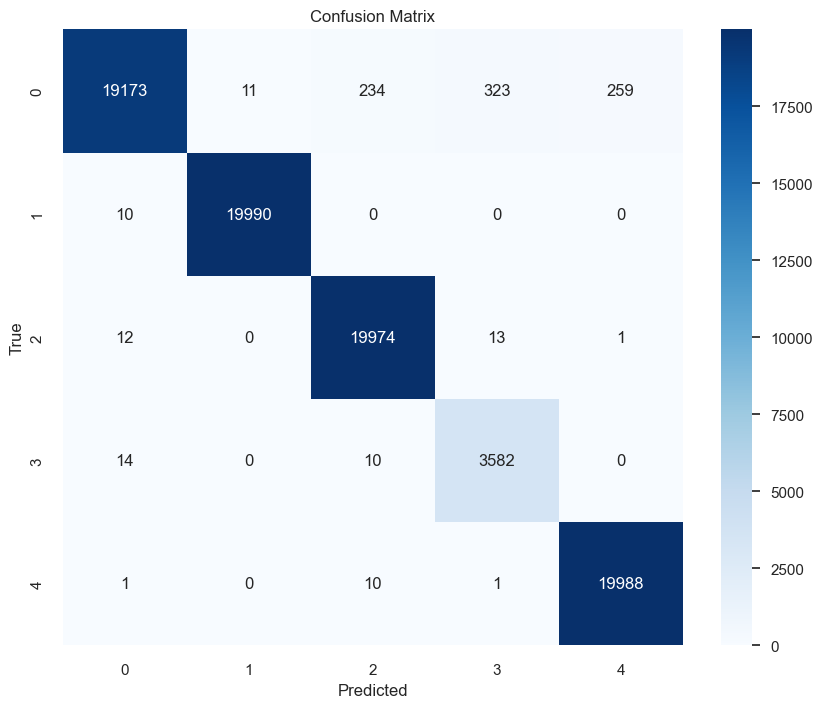

In [28]:
# vẽ confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set(style='whitegrid')
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [29]:
from sklearn.decomposition import PCA

# Giảm chiều dữ liệu với PCA (ví dụ còn 20 chiều)
pca = PCA(n_components=20, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Tạo graph k-NN từ dữ liệu đã giảm chiều
k = 10
A = kneighbors_graph(X_pca, n_neighbors=k, mode='connectivity', include_self=False).tocoo()
edge_index = torch.tensor([A.row, A.col], dtype=torch.long)

data = Data(
    x=torch.tensor(X_pca, dtype=torch.float),
    edge_index=edge_index,
    y=torch.tensor(y, dtype=torch.long)
)
print(f"Graph: {data.num_nodes} nodes, {data.num_edges//2} undirected edges")

num_nodes = data.num_nodes
idx = np.arange(num_nodes)
train_idx, test_idx = train_test_split(
    idx, test_size=0.2, random_state=42, stratify=y
)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask  = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
test_mask [test_idx] = True

data.train_mask = train_mask
data.test_mask  = test_mask

Graph: 418028 nodes, 2090140 undirected edges


In [ ]:
from torch_geometric.nn import GCNConv
from collections import Counter
import torch.nn.functional as F
class GCN(torch.nn.Module):
    def __init__(self, in_feats, hid_feats, num_classes):
        super().__init__()
        self.conv1 = GCNConv(in_feats, hid_feats)
        self.conv2 = GCNConv(hid_feats, hid_feats)
        self.lin   = torch.nn.Linear(hid_feats, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return F.log_softmax(self.lin(x), dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(data.num_node_features, 64, len(le.classes_)).to(device)
data = data.to(device)

# compute class weights
counts = Counter(y)
total = sum(counts.values())
weights = torch.tensor([total/counts[i] for i in range(len(le.classes_))],
                       dtype=torch.float, device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss(weight=weights)

In [ ]:
history = {'loss': [], 'train_acc': [], 'test_acc': []}
best_test, patience, stall = 0.0, 10, 0

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    pred = out.argmax(dim=1)
    train_acc = pred[data.train_mask].eq(data.y[data.train_mask]).float().mean().item()
    test_acc  = pred[data.test_mask].eq(data.y[data.test_mask]).float().mean().item()

    history['loss'].append(loss.item())
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)

    print(f"Epoch {epoch:03d} | Loss {loss:.4f} | "
          f"TrainAcc {train_acc:.4f} | TestAcc {test_acc:.4f}")

    if test_acc > best_test:
        best_test, stall = test_acc, 0
    else:
        stall += 1
        if stall >= patience:
            print("Early stopping.")
            break